# Analysis of 2ns Production Run (45° Rotation of G527)
*Elliot Williams*

Here, I analyze the 2ns of production run of the rotated G527 N1 ribosomal neighbourhood, using [Principal Components Analysis (PCA)](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) and [pytraj].

First, let's load the relevant trajectories into Python (sourced from `home33/weirlab/MDfiles/5JUP_N1/UMBRELLA_G63/` on cottontail)

In [1]:
%load_ext rpy2.ipython

In [2]:
import pytraj as pt
# Loads in trajectories for first 2ns of post-rotational dynamics
traj = pt.iterload(["data/105-dyn1.trj", "data/105-dyn2.trj"], "data/5JUP_N1_wat.prmtop",
                   frame_slice=[(0, 500, 1),]*2)

Note that the original trajectory has a Topology associated with almost 100,000 atoms. This is because each of the atoms within each amino acid and nucleotide is considered; let's fix this by only considering the alpha carbon of each amino acid, and only the C1' of each nucleotide.

In [3]:
traj_n1 = traj["@CA,C1'"]
traj_n1

pytraj.Trajectory, 1000 frames: 
Size: 0.011064 (GB)
<Topology: 495 atoms, 495 residues, 495 mols, PBC with box type = truncoct>
           

Success! Now, let's use the Euclidean position of each of the atoms over the trajectory as input dimensions to PCA.

In [4]:
# compute pca (compute all eigenvectors, eigenvalues)
data = pt.pca(traj, mask="@CA,C1'", n_vecs=-1)

There are 1485 eigenvalues total


Text(0.5,1,'Scree Plot of Atomic Position Variance')

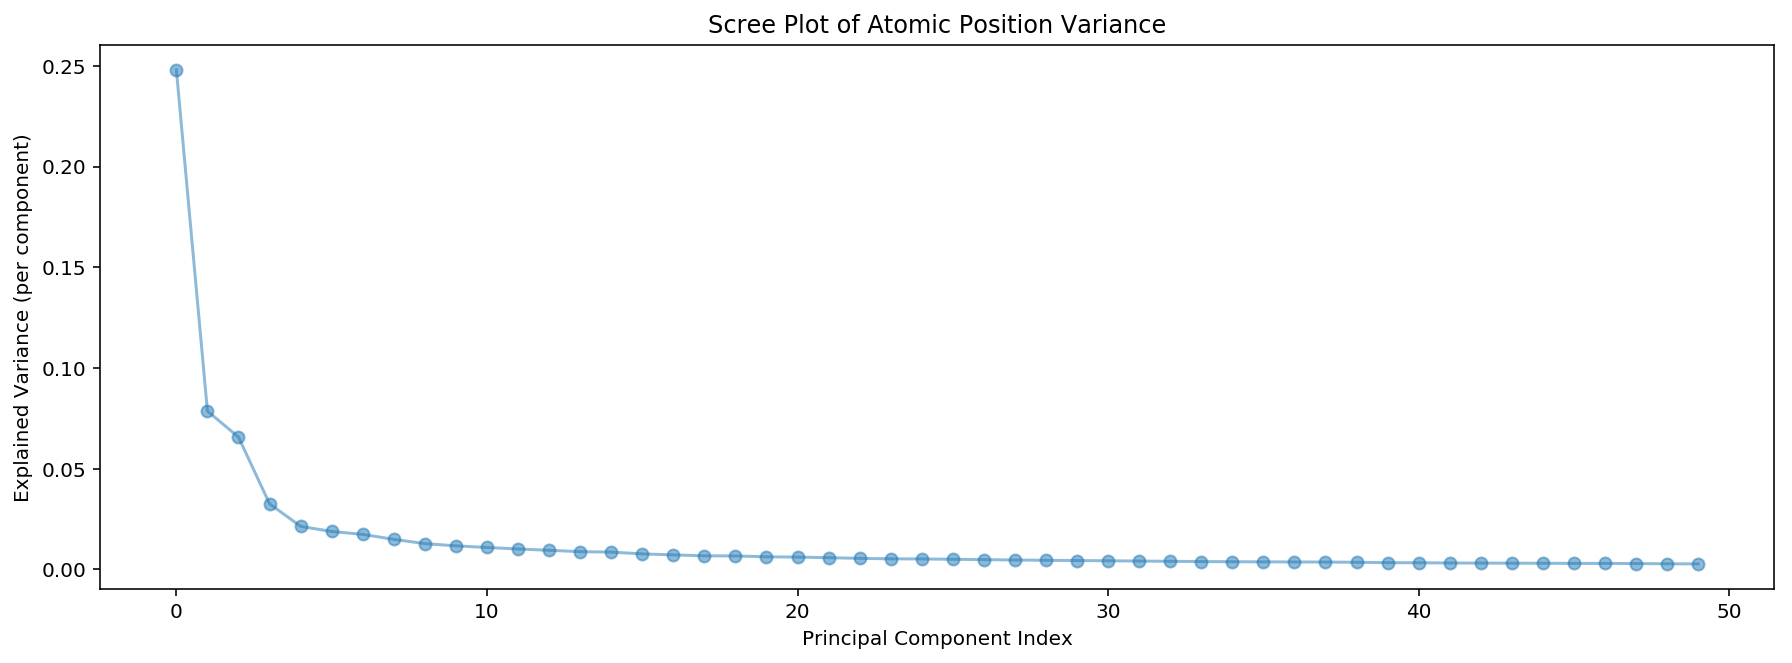

In [99]:
import matplotlib
from matplotlib import pyplot as plt

eigenvalues = data[1][0]
eigenvectors = data[1][1]
eigenval_sum = sum(eigenvalues)
variance_explained = [eigenvalues[i] / eigenval_sum for i in range(len(eigenvalues))]

print("There are {} eigenvalues total".format(len(eigenvalues)))

plt.plot([x for x in range(50)], variance_explained[0:50], marker='o', alpha=0.5)
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance (per component)")
plt.title("Scree Plot of Atomic Position Variance")


Analyzing the Scree plot, 5 principal components would be the most appropriate measure. 

Unfortunately we can only visualize 2, but let's cluster to 5 anyways.

In [6]:
print("{:.5f} of the variance is explained by 2 principal components".format(
    sum(variance_explained[0:2])))
print("{:.5f} of the variance is explained by 5 principal components".format(
    sum(variance_explained[0:5])))

0.32669 of the variance is explained by 2 principal components
0.44640 of the variance is explained by 5 principal components


Now, let's visualize how the trajectory 'wanders' over the first two principal components over the 2ns of trajectory.

In [58]:
import matplotlib
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = [15, 5]




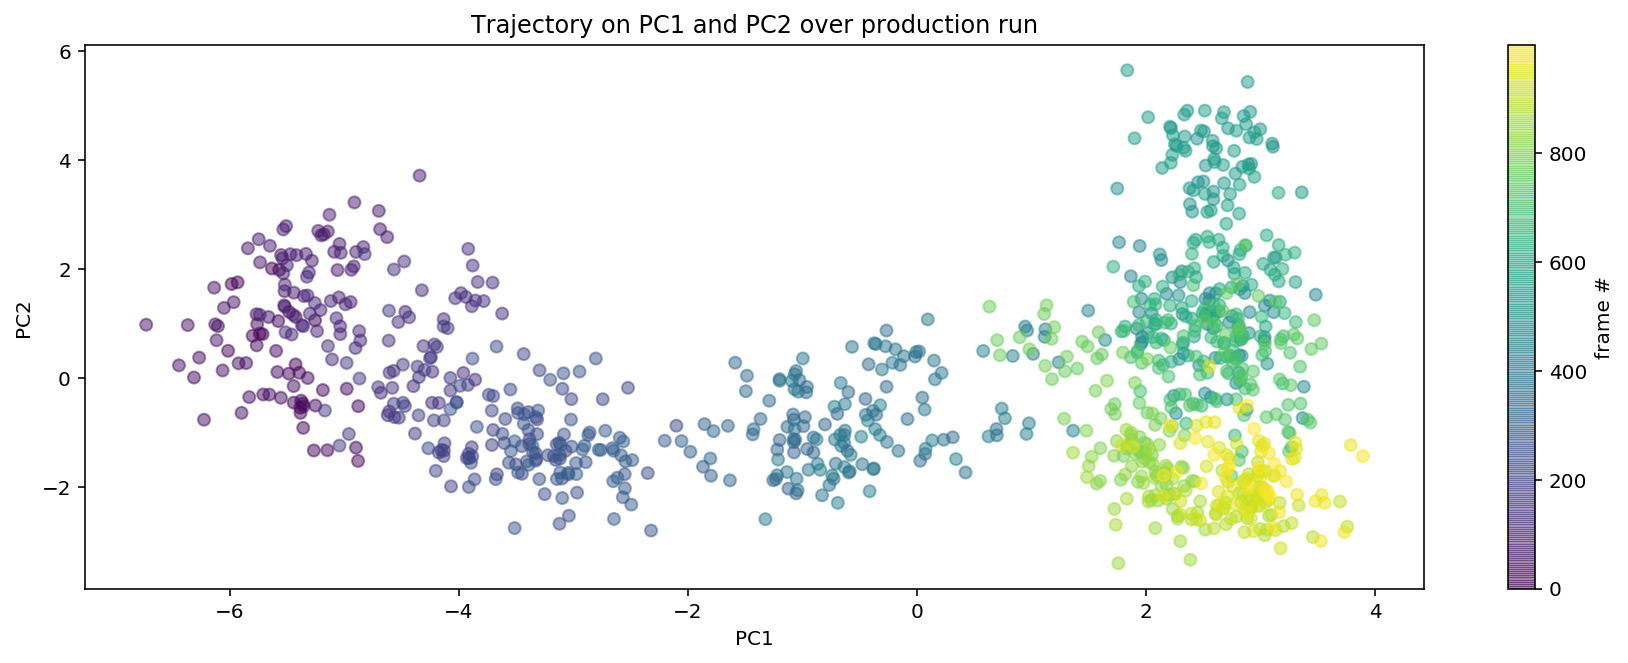

In [114]:
projection_data = data[0]
plt.scatter(projection_data[0], projection_data[1], marker='o', c=range(traj.n_frames), alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Trajectory on PC1 and PC2 over production run')
cbar = plt.colorbar()
cbar.set_label('frame #')  

We can solidly say that the simulation definitely 'wanders' over the course of the 2ns of dynamics. Now, let's cluster the frames within the trajectory on the first 5 principal components in order to obtain some typical values for each cluster which we can then use in our UMBRELLA sampling steps. 

Let's load our 5 PCs into a pandas DataFrame, and start with an Elbow curve to figure out exactly how many clusters we should use

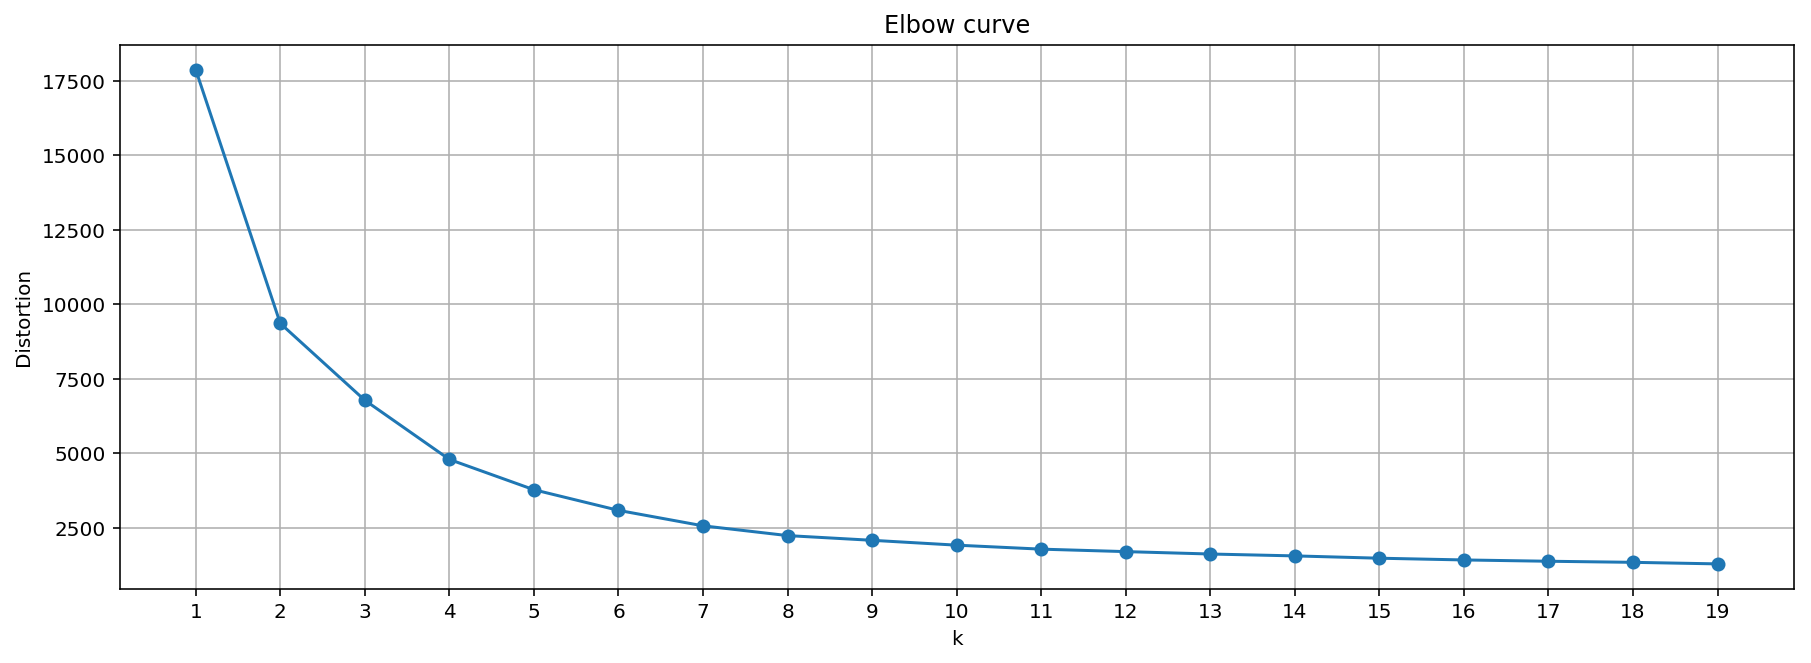

In [59]:
import pandas as pd
import sklearn
import seaborn
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist, pdist


df = pd.DataFrame(data={'PC1': projection_data[0],
                        'PC2': projection_data[1],
                        'PC3': projection_data[2],
                        'PC4': projection_data[3],
                        'PC5': projection_data[4],
                         })

distorsions = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)
    distorsions.append(kmeans.inertia_)


fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 20), distorsions, marker='o')
plt.ylabel("Distortion")
plt.xlabel("k")
plt.grid(True)
plt.title('Elbow curve')
plt.xticks(range(1,20))
plt.show()

To me, there's no clear 'elbow' on this curve, but $k=5$ seems like a reasonable choice.

In [61]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df)
df['labels']  = pd.Series(kmeans.labels_)
df['frame_num'] = pd.Series(range(len(eigenvalues)))

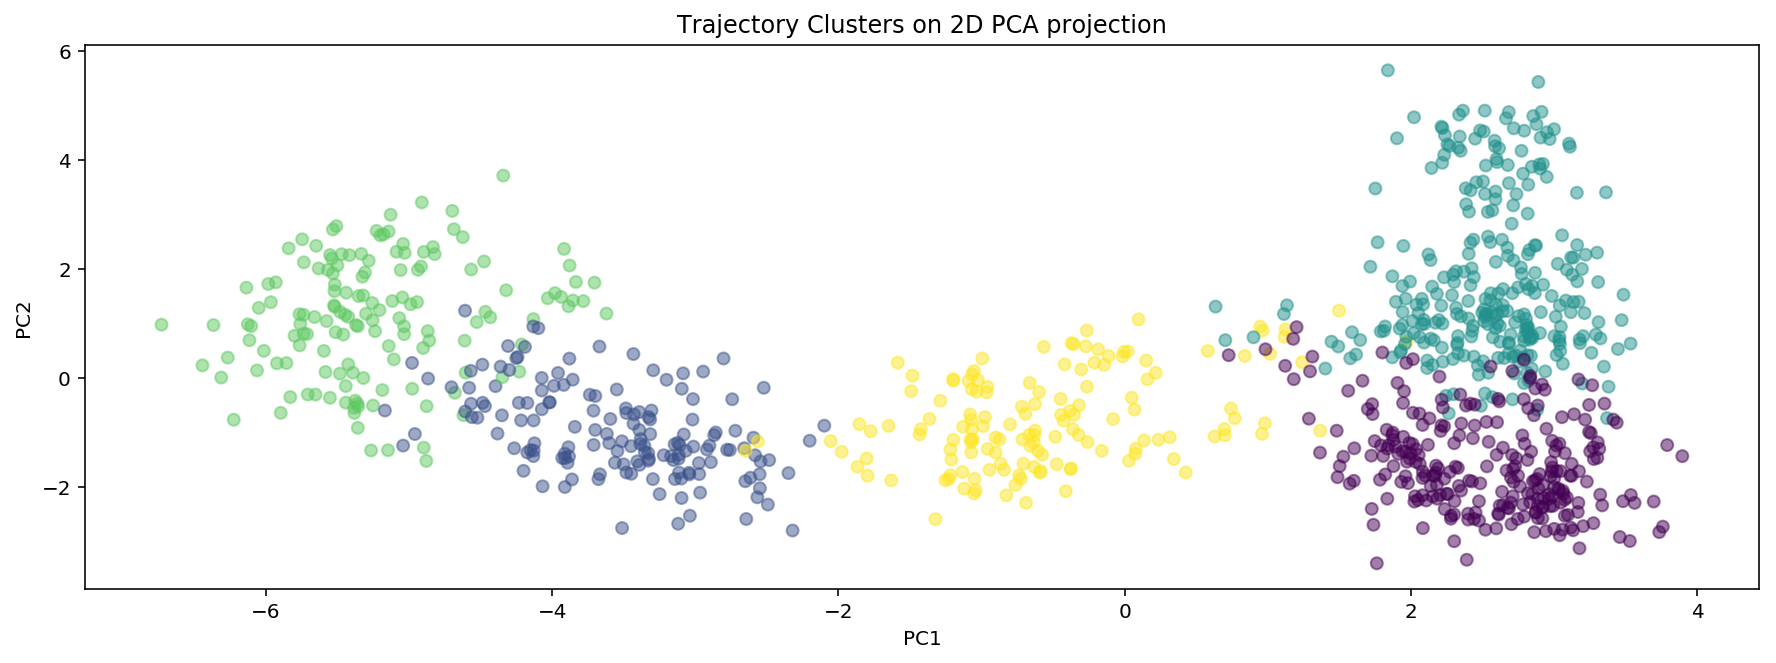

In [62]:
plt.scatter(projection_data[0], projection_data[1], marker='o', c=df['labels'], alpha=0.5)
plt.title("Trajectory Clusters on 2D PCA projection")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

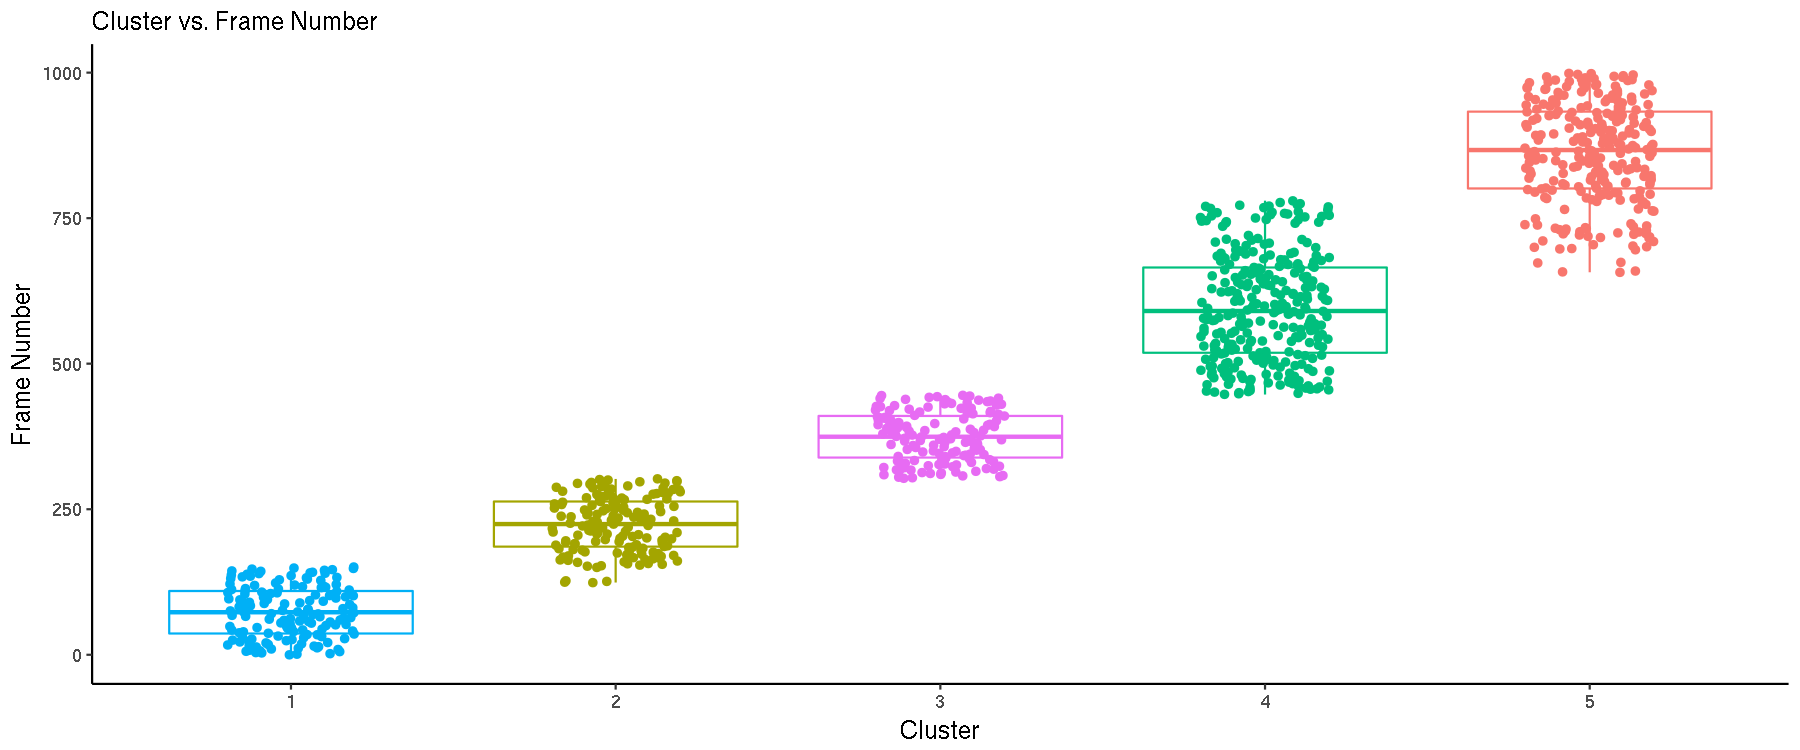

In [113]:
%%R -i df -r 150 -w 12 -h 5 -u in
library(ggplot2)
library(plyr)

theme_set(theme_gray(base_size = 12))
ggplot(df, aes(y=frame_num, group=labels, x=mapvalues(labels, c(0,1,2,3,4), c(5,2,4,1,3)), color=factor(labels))) + geom_boxplot() +
    labs(x="Cluster", y="Frame Number", title="Cluster vs. Frame Number") + geom_jitter(width = 0.2) +
    theme_classic() + theme(legend.position="")



In [112]:
# loads in Korostelev N1s

traj_n1 = traj["@CA,C1'"]

print(traj_n1)

stage1 = pt.load("data/5juo_n1.pdb")["@CA,C1'"]
stage2 = pt.load("data/5jup_n1.pdb")["@CA,C1'"]
stage3 = pt.load("data/5jus_n1.pdb")["@CA,C1'"]
stage4 = pt.load("data/5jut_n1.pdb")["@CA,C1'"]
stage5 = pt.load("data/5juu_n1.pdb")["@CA,C1'"]

# traj_n1.append(pt.load("data/5jus_n1.pdb")["@CA,C1'"])
# traj_n1.append(pt.load("data/5jut_n1.pdb")["@CA,C1'"])
# traj_n1.append(pt.load("data/5juu_n1.pdb")["@CA,C1'"])

print(stage1)

# proj_1 = pt.projection(stage_1, "@CA,C1'", eigenvectors, eigenvalues)
# stage_2 = pt.load("data/5jup_n1.pdb")
# stage_3 = pt.load("data/5jus_n1.pdb")
# stage_4 = pt.load("data/5jut_n1.pdb")
# stage_5 = pt.load("data/5juu_n1.pdb")

# proj_1 = pt.projection(stage_1, "@CA,C1'", eigenvectors[:5], eigenvalues[:5], 'covar')

pytraj.Trajectory, 1000 frames: 
Size: 0.011064 (GB)
<Topology: 495 atoms, 495 residues, 495 mols, PBC with box type = truncoct>
           
pytraj.Trajectory, 1 frames: 
Size: 0.000011 (GB)
<Topology: 495 atoms, 495 residues, 495 mols, non-PBC>
           


In [ ]:
for frame in stage_1:
    print(frame)